import torch
import torch.nn as nn

triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
anchor = torch.randn(100, 128, requires_grad=True)
positive = torch.randn(100, 128, requires_grad=True)
negative = torch.randn(100, 128, requires_grad=True)
output = triplet_loss(anchor, positive, negative)
output.backward()

from decord import VideoReader, cpu
import numpy as np

from transformers import VideoMAEImageProcessor, VideoMAEModel
from huggingface_hub import hf_hub_download


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices




# video clip consists of 300 frames (10 seconds at 30 FPS)
file_path = hf_hub_download(
    repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset"
)
videoreader = VideoReader(file_path, num_threads=1, ctx=cpu(0))

# sample 16 frames
videoreader.seek(0)
indices = sample_frame_indices(clip_len=16, frame_sample_rate=4, seg_len=len(videoreader))
video = videoreader.get_batch(indices).asnumpy()


In [1]:
import numpy as np

from transformers import VideoMAEImageProcessor, VideoMAEModel

2022-12-19 15:26:04.361940: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 15:26:04.439582: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-19 15:26:04.851207: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-19 15:26:04.851238: W tensorflow/

In [2]:

from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

In [3]:
model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")


In [4]:

image_processor = VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base")
#model = VideoMAEModel.from_pretrained("MCG-NJU/videomae-base")

# prepare video for the model
#inputs = image_processor(list(video), return_tensors="pt")

# forward pass
#outputs = model(**inputs)
#last_hidden_states = outputs.last_hidden_state
#list(last_hidden_states.shape)

In [5]:
#inputs['pixel_values'].shape

In [6]:
#import torch

In [7]:
#inputs = torch.randn(1,16,3, 224, 224, requires_grad=False)

In [8]:

#outputs = model(inputs)

In [9]:
#outputs.last_hidden_state

In [10]:
model_ckpt = "MCG-NJU/videomae-base"
batch_size = 8

In [11]:
from transformers import VideoMAEFeatureExtractor

In [12]:
#dataset_root_path = '/data/ZHO/formats/ucf101_letters_only_avi/'
dataset_root_path = '/data/ZHO/formats/ucf101_letters_only/'

feature_extractor = VideoMAEFeatureExtractor.from_pretrained(model_ckpt)
 

In [13]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [14]:
import os

mean = feature_extractor.image_mean
std = feature_extractor.image_std
resize_to = feature_extractor.size['shortest_edge']
print(resize_to)
num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
#clip_duration = num_frames_to_sample * sample_rate / fps
clip_duration =10
print(clip_duration)

# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    #RandomShortSideScale(min_size=256, max_size=320),
                    Resize((resize_to,resize_to)),
                    #RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)
# Training dataset.
train_dataset = pytorchvideo.data.labeled_video_dataset(
#    data_path=os.path.join(dataset_root_path, "train"),
    data_path = os.path.join(dataset_root_path,'annotations','trainlist01.txt'),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize((resize_to, resize_to)),
                ]
            ),
        ),
    ]
)



224
10


In [15]:
'''
# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)
test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)
'''

'\n# Validation and evaluation datasets.\nval_dataset = pytorchvideo.data.Ucf101(\n    data_path=os.path.join(dataset_root_path, "val"),\n    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),\n    decode_audio=False,\n    transform=val_transform,\n)\ntest_dataset = pytorchvideo.data.Ucf101(\n    data_path=os.path.join(dataset_root_path, "test"),\n    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),\n    decode_audio=False,\n    transform=val_transform,\n)\n'

In [16]:
# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Kinetics(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)
test_dataset = pytorchvideo.data.Kinetics(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [17]:
from torch.utils.data import DataLoader


In [18]:
batch_size = 2

In [19]:

#train_dataset = pytorchvideo.data.Ucf101(data_path=dataset_root_path, transform=train_transform, clip_sampler=sampler)
# dataset = UCF101(root=img_path, annotation_path=annotation_path, frames_per_clip=16, transform=transform)


train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers=1)  

In [20]:
#iterator=iter(train_dataloader)

In [21]:
import time

In [22]:
train_dataset.num_videos


64

In [23]:
import torch.functional  as F

In [24]:
import torch.nn as nn

In [25]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x


In [26]:
model.classifier = Identity()

In [27]:
model.cuda()

VideoMAEForVideoClassification(
  (videomae): VideoMAEModel(
    (embeddings): VideoMAEEmbeddings(
      (patch_embeddings): VideoMAEPatchEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
    )
    (encoder): VideoMAEEncoder(
      (layer): ModuleList(
        (0): VideoMAELayer(
          (attention): VideoMAEAttention(
            (attention): VideoMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): VideoMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VideoMAEIntermediate(
            (dense): Linear(in_f

In [28]:
import torch

In [36]:
outputs = []
labels = []
for i,j in enumerate(train_dataloader):
    #print(j['video'].shape,j['label'].shape)
    start = time.time()
    input = j['video'].permute(0,2,1,3,4).cuda()
    print(input.shape)
    end = time.time()
    #print(end-start)
    #print(model(input).last_hidden_state.shape, j['label'])
    #print(j['label'])
    #print(j['video_name'])
    #print(j['video_index'])
    #print(j['clip_index'])
    #print(j['aug_index'])
    #print(j[])
    #print(j)
    
    #model.layernorm()
    y = model(input).logits
    print(y.shape)
    
    outputs.append(y.detach().cpu().numpy())
    labels.append(j['label'].numpy())
    
    #k = torch.nn.AvgPool2d()
    #print(k(y).shape)
    #average = torch.mean(y,dim =1 )
    #print(average.shape)

#'video_name'
#'video_index'
#'clip_index'
#'aug_index'
#'label'

torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 224])
torch.Size([2, 768])
torch.Size([2, 16, 3, 224, 2

In [41]:
eee = np.stack(outputs).reshape(64,768)
labels = np.stack(labels).reshape(64)

In [42]:
print(eee.shape)
print(labels.shape)

(64, 768)
(64,)


In [43]:
labels

array([24, 15, 18,  3, 29, 10, 25, 22,  1, 31, 19, 26, 12, 27, 23, 29, 13,
        7,  5, 13,  2, 10, 11,  3,  6, 21, 17,  0, 21, 28,  9, 25, 14, 11,
       14, 17, 16, 20, 23, 19, 20, 27, 24,  9, 30, 28, 15,  2,  4, 16,  8,
       31,  1,  7,  8, 22, 26, 12, 30,  0, 18,  5,  4,  6])

In [44]:
from sklearn.decomposition import PCA


In [46]:
pca = PCA(n_components = 2)
temp=eee-np.mean(eee,axis=0)
a=pca.fit_transform(temp)

In [47]:
print(a.shape)

(64, 2)


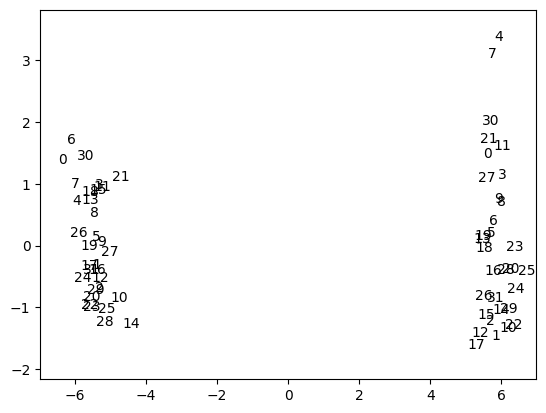

In [48]:
# Сонгож авсан үгнүүдээ хавтгайд байгуулж харъя
import matplotlib.pyplot as plt
plt.figure()
for i in range(len(labels)):
    plt.text(a[i][0],a[i][1],labels[i])
    
plt.xlim((np.min(a[:,0])-0.5, np.max(a[:,0])+0.5))
plt.ylim((np.min(a[:,1])-0.5, np.max(a[:,1])+0.5))
plt.show()

In [ ]:
import torch.nn as nn


In [ ]:
import fiftyone as fo

ModuleNotFoundError: No module named 'fiftyone'

In [ ]:
from decord import VideoReader, cpu
import torch
import numpy as np

from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
from huggingface_hub import hf_hub_download

np.random.seed(0)


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices


# video clip consists of 300 frames (10 seconds at 30 FPS)
file_path = hf_hub_download(
    repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset"
)
videoreader = VideoReader(file_path, num_threads=1, ctx=cpu(0))

# sample 16 frames
videoreader.seek(0)
indices = sample_frame_indices(clip_len=16, frame_sample_rate=4, seg_len=len(videoreader))
video = videoreader.get_batch(indices).asnumpy()

image_processor = VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")
model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")

inputs = image_processor(list(video), return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# model predicts one of the 400 Kinetics-400 classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

2022-12-19 15:17:44.116625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 15:17:44.225198: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-19 15:17:44.671725: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-19 15:17:44.671771: W tensorflow/

eating spaghetti


NameError: name 'nn' is not defined

NameError: name 'Identity' is not defined

In [ ]:
from torchinfo import summary
#model.to('cuda') #always need to send the model to cuda before running this command
summary(model,input_size = (1,16,3,224,224))

Layer (type:depth-idx)                                       Output Shape              Param #
VideoMAEForVideoClassification                               [1, 400]                  --
├─VideoMAEModel: 1-1                                         [1, 1568, 768]            --
│    └─VideoMAEEmbeddings: 2-1                               [1, 1568, 768]            --
│    │    └─VideoMAEPatchEmbeddings: 3-1                     [1, 1568, 768]            1,180,416
│    └─VideoMAEEncoder: 2-2                                  [1, 1568, 768]            --
│    │    └─ModuleList: 3-2                                  --                        85,045,248
├─LayerNorm: 1-2                                             [1, 768]                  1,536
├─Linear: 1-3                                                [1, 400]                  307,600
Total params: 86,534,800
Trainable params: 86,534,800
Non-trainable params: 0
Total mult-adds (G): 1.91
Input size (MB): 9.63
Forward/backward pass size (MB): 934

In [ ]:
model

VideoMAEForVideoClassification(
  (videomae): VideoMAEModel(
    (embeddings): VideoMAEEmbeddings(
      (patch_embeddings): VideoMAEPatchEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
    )
    (encoder): VideoMAEEncoder(
      (layer): ModuleList(
        (0): VideoMAELayer(
          (attention): VideoMAEAttention(
            (attention): VideoMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): VideoMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VideoMAEIntermediate(
            (dense): Linear(in_f

In [ ]:
#from torchsummary import summary
from torchinfo import summary
#model.to('cuda') #always need to send the model to cuda before running this command
summary(model,input_size = (1,16,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
VideoMAEModel                                           [1, 1568, 768]            --
├─VideoMAEEmbeddings: 1-1                               [1, 1568, 768]            --
│    └─VideoMAEPatchEmbeddings: 2-1                     [1, 1568, 768]            --
│    │    └─Conv3d: 3-1                                 [1, 768, 8, 14, 14]       1,180,416
├─VideoMAEEncoder: 1-2                                  [1, 1568, 768]            --
│    └─ModuleList: 2-2                                  --                        --
│    │    └─VideoMAELayer: 3-2                          [1, 1568, 768]            7,087,104
│    │    └─VideoMAELayer: 3-3                          [1, 1568, 768]            7,087,104
│    │    └─VideoMAELayer: 3-4                          [1, 1568, 768]            7,087,104
│    │    └─VideoMAELayer: 3-5                          [1, 1568, 768]            7,087,104
│    │    └─VideoMAELayer

In [ ]:
import torch.nn as nn
# NLP Example
batch, sentence_length, embedding_dim = 20, 5, 10
embedding = torch.randn(batch, sentence_length, embedding_dim)
layer_norm = nn.LayerNorm(embedding_dim)
# Activate module
layer_norm(embedding)
# Image Example
N, C, H, W = 20, 5, 10, 10
input = torch.randn(N, C, H, W)
# Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
# as shown in the image below
layer_norm = nn.LayerNorm([C, H, W])
output = layer_norm(input)

output.shape

torch.Size([20, 5, 10, 10])

In [ ]:

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/VideoMAE')

In [ ]:
input = torch.rand([1,16,3,224,224])

In [ ]:
dataiter = iter(train_dataloader)
a = next(dataiter)

In [ ]:

print(a)

{'video': tensor([[[[[ 1.0159e+00,  1.0502e+00,  1.0502e+00,  ...,  3.8231e-01,
             3.3094e-01,  3.8231e-01],
           [ 1.0331e+00,  1.0547e+00,  1.0502e+00,  ...,  3.4717e-01,
             3.4806e-01,  4.0212e-01],
           [ 1.0287e+00,  1.0358e+00,  1.0502e+00,  ...,  3.4806e-01,
             3.4042e-01,  3.9362e-01],
           ...,
           [ 3.0780e-01,  3.1381e-01,  2.5479e-01,  ..., -7.0034e-02,
             2.8342e-03, -1.5228e-02],
           [ 2.6244e-01,  2.7345e-01,  2.4531e-01,  ..., -1.1559e-02,
            -1.7676e-02, -2.9667e-02],
           [ 2.4531e-01,  2.4531e-01,  2.4531e-01,  ..., -4.4279e-02,
            -4.2748e-02, -5.8062e-02]],

          [[ 1.0159e+00,  1.0477e+00,  1.0502e+00,  ...,  3.6519e-01,
             3.4806e-01,  3.4806e-01],
           [ 1.0258e+00,  1.0361e+00,  1.0673e+00,  ...,  3.4806e-01,
             3.4806e-01,  3.6158e-01],
           [ 1.0331e+00,  1.0538e+00,  1.0602e+00,  ...,  3.7283e-01,
             3.4533e-01,  3.63

In [ ]:
writer.add_graph(model, a['video'].permute(0,2,1,3,4))
writer.close()

/projects/transformers/src/transformers/models/videomae/modeling_videomae.py:191: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
/projects/transformers/src/transformers/models/videomae/modeling_videomae.py:195: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != self.image_size[0] or width != self.image_size[1]:


Encountering a dict at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
Error occurs, No graph saved


RuntimeError: Encountering a dict at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.

In [ ]:

from torchviz import make_dot

make_dot(model)

AttributeError: 'VideoMAEForVideoClassification' object has no attribute 'size'

In [ ]:
yhat = model(a['video'].permute(0,2,1,3,4))

In [ ]:
make_dot(yhat, params=dict(model.named_parameters()))

TypeError: unhashable type: 'BaseModelOutput'

In [ ]:
from collections import namedtuple
from typing import Any

import torch


# pylint: disable = abstract-method
class ModelWrapper(torch.nn.Module):
    """
    Wrapper class for model with dict/list rvalues.
    """

    def __init__(self, model: torch.nn.Module) -> None:
        """
        Init call.
        """
        super().__init__()
        self.model = model

    def forward(self, input_x: torch.Tensor) -> Any:
        """
        Wrap forward call.
        """
        data = self.model(input_x)

        if isinstance(data, dict):
            data_named_tuple = namedtuple("ModelEndpoints", sorted(data.keys()))  # type: ignore
            data = data_named_tuple(**data)  # type: ignore

        elif isinstance(data, list):
            data = tuple(data)

        return data

In [ ]:
model_wrapper = ModelWrapper(model)
writer.add_graph(model_wrapper,  a['video'].permute(0,2,1,3,4))